A Dockerfile that will produce a container with all the dependencies necessary to run this notebook is available [here](https://github.com/AustinRochford/notebooks).

In [1]:
%matplotlib inline

In [2]:
from warnings import filterwarnings

In [3]:
from matplotlib import pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import numpy as np
import seaborn as sns

In [4]:
# configure pyplot for readability when rendered as a slideshow and projected
plt.rc('figure', figsize=(8, 6))

LABELSIZE = 14
plt.rc('axes', labelsize=LABELSIZE)
plt.rc('axes', titlesize=LABELSIZE)
plt.rc('figure', titlesize=LABELSIZE)
plt.rc('legend', fontsize=LABELSIZE)
plt.rc('xtick', labelsize=LABELSIZE)
plt.rc('ytick', labelsize=LABELSIZE)

plt.rc('animation', writer='avconv')

In [5]:
filterwarnings('ignore', 'findfont')

In [6]:
blue, green, red, purple, gold, teal = sns.color_palette()

pct_formatter = StrMethodFormatter('{x:.1%}')

In [7]:
SEED = 755954 # from random.org, for reproducibility

np.random.seed(SEED)

# Open Source Bayesian Inference in Python with PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>


## FOSSCON &#8226; Philadelphia &#8226; August 26, 2017

## [@AustinRochford](https://twitter.com/AustinRochford)

## Who am I?

<center><img src='http://austinrochford.com/resources/img/face_big.png' width=400></center>

### [@AustinRochford](https://twitter.com/AustinRochford) &#8226; [arochford@monetate.com](mailto:arochford@monetate.com)

### PyMC3 developer &#8226; Principal Data Scientist at [Monetate Labs](http://www.monetate.com/)

## Bayesian Inference

A motivating question:

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

### Conditional Probability

[_Conditional probability_](https://en.wikipedia.org/wiki/Conditional_probability) is the probability that one event will happen, given that another event has occured.

$$
\begin{align*}
P(A\ |\ B)
    & = \textrm{the probability that } A \textrm{ will happen if we know that } B \textrm{ has happened} \\
    & = \frac{P(A \textrm{ and } B)}{P(B)}.
\end{align*}
$$

Our question,

> A rare disease is present in one out of one hundred thousand people.  A test gives the correct diagnosis 99.9% of the time.  What is the probability that a person that tests positive has the disease?

becomes

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & =\ \textbf{?}
\end{align*}
$$

### Bayes' Theorem

[Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem) shows how to get from $P(B\ |\ A)$ to $P(A\ |\ B)$.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/1/18/Bayes%27_Theorem_MMB_01.jpg/1200px-Bayes%27_Theorem_MMB_01.jpg' width=400></center>

The first step below follows from Bayes' theorem, the second step follows from the [law of total probability](https://en.wikipedia.org/wiki/Law_of_total_probability).

$$
\begin{align*}
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +)} \\
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)}
\end{align*}
$$

$$
\begin{align*}
    P(+)
        & = 10^{-5} \\
    P(\textrm{Test } +\ |\ +)
        & = 0.999 \\
    P(\textrm{Test } -\ |\ -)
        & = 0.999 \\
    \\
    P(+\ |\ \textrm{Test } +)
        & = \frac{P(\textrm{Test } +\ |\ +) P(+)}{P(\textrm{Test } +\ |\ +) P(+) + P(\textrm{Test } +\ |\ -) P(-)} \\
        & = \frac{0.999 \times 10^{-5}}{0.999 \times 10^{-5} + 0.001 \times \left(1 - 10^{-5}\right)}
\end{align*}
$$

Strikingly, a person that tests positive has a less than 1% chance of actually having the disease!  (Worryingly few doctors get this question right when asked. **CITATION NEEDED**)

In [8]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

## Probilistic Programming with PyMC3

<center><img src='https://raw.githubusercontent.com/pymc-devs/pymc3/master/docs/pymc3_logo.jpg'></center>

This calculation was tedious to do by hand, and only had a closed form answer because of the simplicity of this situation.

<center><img src="https://automatetheboringstuff.com/images/automate_cover_medium.png"></center>

In [9]:
import pymc3 as pm

with pm.Model() as disease_model:
    has_disease = pm.Bernoulli('has_disease', 1e-5)
    
    p_test_pos = has_disease * 0.999 + (1 - has_disease) * 0.001
    test_pos = pm.Bernoulli('test_pos', p_test_pos, observed=1)

In [10]:
with disease_model:
    disease_trace = pm.sample(draws=10000, random_seed=SEED)

Assigned BinaryGibbsMetropolis to has_disease
100%|██████████| 10500/10500 [00:02<00:00, 3895.41it/s]


In [11]:
pm.trace_to_dataframe(disease_trace).head()

,has_disease
0,0
1,0
2,0
3,0
4,0


In [12]:
disease_trace['has_disease'].mean()

0.0094000000000000004

In [13]:
0.999 * 1e-5 / (0.999 * 1e-5 + 0.001 * (1 - 1e-5))

0.009891284975940117

### Probabilistic Programming

#### Data science &mdash; inference enables storytelling

<center><img src="https://www.edwardtufte.com/tufte/graphics/minard_lg.gif" width="800">

#### Probabilistic programming &mdash; storytelling enables inference

<center><img src="http://austinrochford.com/resources/talks/img/prob_prog_png.png"></center>

#### The Monty Hall Paradox

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

Initially, we have no information about which door the prize is behind.

In [14]:
with pm.Model() as monty_model:
    prize = pm.DiscreteUniform('prize', 0, 2)

If we choose door one:

<table>
    <tr>
        <td></td>
        <th colspan="3"><center>Monty can open</center></th>
    </tr>
    <tr>
        <th>Prize behind</th>
        <td>Door 1</td>
        <td>Door 2</td>
        <td>Door 3</td>
    </tr>
    <tr>
        <td>Door 1</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
    </tr>
    <tr>
        <td>Door 2</td>
        <td><font color="red">No</font></td>
        <td><font color="green">Yes</font></td>
        <td><font color="red">No</font></td>
    </tr>
</table>

In [15]:
from theano import tensor as tt

with monty_model:
    p_open = pm.Deterministic('p_open',
                              tt.switch(tt.eq(prize, 0),
                                        # it is behind the first door
                                        np.array([0., 0.5, 0.5]),
                              tt.switch(tt.eq(prize, 1),
                                        # it is behind the second door
                                        np.array([0., 0., 1.]),
                                        # it is behind the third door
                                        np.array([0., 1., 0.]))))

Monty opened the third door, revealing a goat.

<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/Monty_open_door.svg/640px-Monty_open_door.svg.png'></center>

In [16]:
with monty_model:
    opened = pm.Categorical('opened', p_open, observed=2)

Should we switch our choice of door?

In [17]:
with monty_model:
    monty_trace = pm.sample(random_seed=SEED)
    
monty_df = pm.trace_to_dataframe(monty_trace)

Assigned Metropolis to prize
100%|██████████| 1000/1000 [00:00<00:00, 4725.84it/s]


In [18]:
monty_df.prize.head()

0    1
1    1
2    1
3    1
4    1
Name: prize, dtype: int64

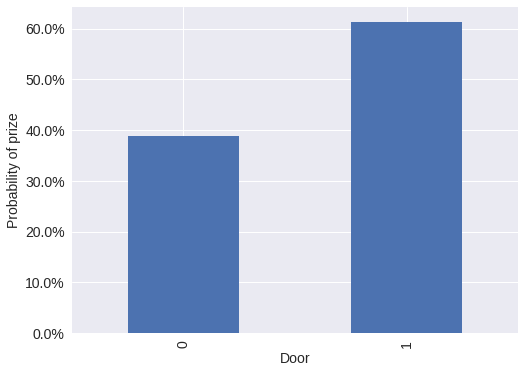

In [19]:
ax = (monty_df.groupby('prize')
              .size()
              .div(monty_df.shape[0])
              .plot(kind='bar'))

ax.set_xlabel("Door");
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_ylabel("Probability of prize");

In [20]:
%%bash
jupyter nbconvert \
    --to=slides \
    --reveal-prefix=https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.2.0/ \
    --output=os-bayes-pymc3-fosscon-2017 \
    ./Open\ Source\ Bayesian\ Inference\ in\ Python\ with\ PyMC3.ipynb

[NbConvertApp] Converting notebook ./Open Source Bayesian Inference in Python with PyMC3.ipynb to slides
[NbConvertApp] Writing 295969 bytes to ./os-bayes-pymc3-fosscon-2017.slides.html
